In [1]:
from __future__ import division
from __future__ import print_function
import numpy as np
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

epsilon = 1e-8    # for floating pt. computation

# all the linear constraints are written as Mz <= b
# M is a matrix, z and b are (column) vectors

M = 0
b = 0
d = 0    # number of unknow parameters, i.e. dimension of space
    

def computeI(v, ineq):
    """
        computeI takes a vertex v and the tight inequality ineq at v, and outputs
        the set I of tight inequalities at v and the position of ineq in I.
        input:  v:      column vector
                ineq:   label of the inequality
        output: I:      vector of labels of tight inequalities
                s:      index of ineq in I 
    """
    
    I = np.argwhere( np.abs(M.dot(v)-b) < epsilon ).ravel()
    s = np.argwhere(I==ineq)[0][0]
    return I, s


def computenextvertex(v, ineq):
    """
        computenextvertex takes a vertex v and a tight inequality ineq at v,
        and outputs another vertex v (the next vertex) after leaving ineq at v 
        and iimin (the new label acquired) - which
        captures the newly tight inequality at the new v.
    """
    
    I, s = computeI(v, ineq)
    l = I.shape[0]
    if l>d:
        print("Degeneracy")
    elif l<d:
        print('Not a vertex')
    
    dirs = -np.linalg.inv(M[I,:])[:, s]    # direction of the edge
    iimin = 0
    betamin = np.inf
    for i in range(M.shape[0]):
        alpha = np.dot(M[i,:], dirs)
        # positive alpha means the constraint is in the correct direction
        if (not (i in I)) and alpha>0:
            beta = (b[i]-np.dot(M[i,:],v)) / alpha
            if beta<betamin:
                betamin = beta
                iimin = i
    if betamin==np.inf:
        return v, None
    v = v+betamin*dirs
    return v, iimin


def LH(A,B,k=0):
    """
        we assume 0 < A_{ij},B_{ij} <1 for all i,j
        returns Nash equilibrium found by the Lemke-Howson algorithm 
        starting with (0,0) and label k, 1 <= k <= m+n
    """
    global M, b, d
    m, n = A.shape
    d = m+n
    
    # let's first write all the linear constraints {Ay <= 1; x^TB <= 1; x >= 0; y >= 0} 
    # as Mz <= b  where z=(x y)
    M = np.vstack([np.hstack([np.zeros([m,m]), A]), \
                   np.hstack([B.transpose(), np.zeros([n,n])]), \
                   np.hstack([-np.identity(m), np.zeros([m,n])]), \
                   np.hstack([np.zeros([n,m]), -np.identity(n)])])
    b = np.hstack([np.ones(m+n), np.zeros(m+n)])
    
#     v = np.array([1/4,1/12,0,1/4,1/12,0])
    v = np.zeros(d)    # starting vertex
    v, iimin = computenextvertex(v, m+n+k)
    count = 0    # it will store the number of pivotings 
    while iimin!=k and iimin!=d+k:    # while label k is not achieved
        count += 1
        if iimin<d:
            v, iimin = computenextvertex(v, iimin+d)
        else:
            v, iimin = computenextvertex(v, iimin-d)
    x = v[:m] / np.sum(v[:m])
    y = v[m:] / np.sum(v[m:])
    return x, y


def Lemke(A, q):
    global M, b, d
    m, n = A.shape
    d = m+1
    M = np.vstack([np.hstack([A, -np.ones([m,1])]), -np.identity(m+1)])
    b = np.hstack([q, np.zeros(m+1)])
    
    if(min(q)>0):
        return np.zeros(m), 0
    v = np.zeros(d)    # starting vertex
    iimin = np.argmin(q)
    v[m] = -q[iimin]
    count = 0    # it will store the number of pivotings 
    while v[m]>epsilon:    # while label k is not achieved
        count += 1
        if iimin<m:
            v, iimin = computenextvertex(v, iimin+m)
        else:
            v, iimin = computenextvertex(v, iimin-m)
        if iimin is None:
            return None, count
    return v[:m] / np.sum(v[:m]), count


print("check Lemke-Howson algorithm using problem 5 in homework 1")
A = np.array([[3,3,0],[4,0,1],[0,4,5]])
x, y = LH(A, A.transpose(), k=2)
print("allocation for x", x)
print("allocation for y", y)

print("check Lemke algorithm using the same problem")
M0 = np.vstack([np.hstack([np.zeros([3,3]), A]), \
               np.hstack([A, np.zeros([3,3])])])
v, pivot = Lemke(M0, np.ones(6))
print("allocation", v, "pivot", pivot)

check Lemke-Howson algorithm using problem 5 in homework 1
allocation for x [ 0.  0.  1.]
allocation for y [ 0.  0.  1.]
check Lemke algorithm using the same problem
allocation [ 0.  0.  0.  0.  0.  0.] pivot 0


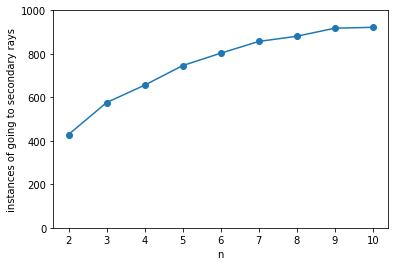

In [2]:
np.random.seed(123)
numbers = []
for n in range(2,11):
    count = 0
    for _ in range(1000):
        A = 10-20*np.random.random([n,n])
        q = 1-2*np.random.random(n)
        v, pivot = Lemke(A, q)
        if v is None:
            count += 1
    numbers.append(count)

plt.figure()
plt.plot(range(2,11), numbers, 'o-')
plt.xlabel("n")
plt.ylabel("instances of going to secondary rays")
plt.ylim([0,1000])
plt.show()

n = 2, time: 0 s
n = 3, time: 1 s
n = 4, time: 3 s
n = 5, time: 6 s
n = 6, time: 10 s
n = 7, time: 15 s
n = 8, time: 23 s
n = 9, time: 31 s
n = 10, time: 45 s


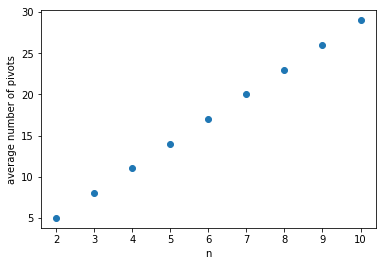

In [3]:
np.random.seed(123)
numbers = []
for n in range(2,11):
    start = time()
    count = []
    for _ in range(1000):
        U = 10*np.random.random([n,n])
        M0 = np.random.random(n)
        W = np.tile(M0.reshape([n,1])/np.sum(M0), [1,n])
        
        # form LCP with parameters {f_ij, p_j, lambda_i}
        temp = np.zeros([n*n,n])
        temp[np.arange(n*n), np.tile(np.arange(n), n)] = U.ravel()
        A = np.vstack([np.hstack([np.zeros([n*n,n*n]), np.tile(-np.identity(n),[n,1]), temp]), \
                       np.hstack([np.tile(np.identity(n),[1,n]), -np.identity(n), np.zeros([n,n])]), \
                       np.hstack([-np.tile(np.identity(n),[1,n]), W, np.zeros([n,n])])])
        q = np.hstack([np.ones(n*n+n), -np.sum(W, axis=1)])
        v, pivot = Lemke(A, q)
        if v is None:
            print("Secondary ray!")
        count.append(pivot)
    numbers.append(count)
    print("n = {}, time: {:d} s".format(n, int(time()-start)))

plt.figure()
plt.plot(range(2,11), np.mean(numbers, axis=1), 'o')
plt.xlabel("n")
plt.ylabel("average number of pivots")
plt.show()